In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

In [2]:
IMG_HEIGHT = 176
IMG_WIDTH = 208
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)


Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_ds = image_generator.flow_from_directory(batch_size=8,
                                                 directory='./output/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

val_ds = image_generator.flow_from_directory(batch_size=8,
                                                 directory='./output/test',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 3278 images belonging to 4 classes.
Found 102 images belonging to 4 classes.


In [3]:
class_name=train_ds.class_names
class_name

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

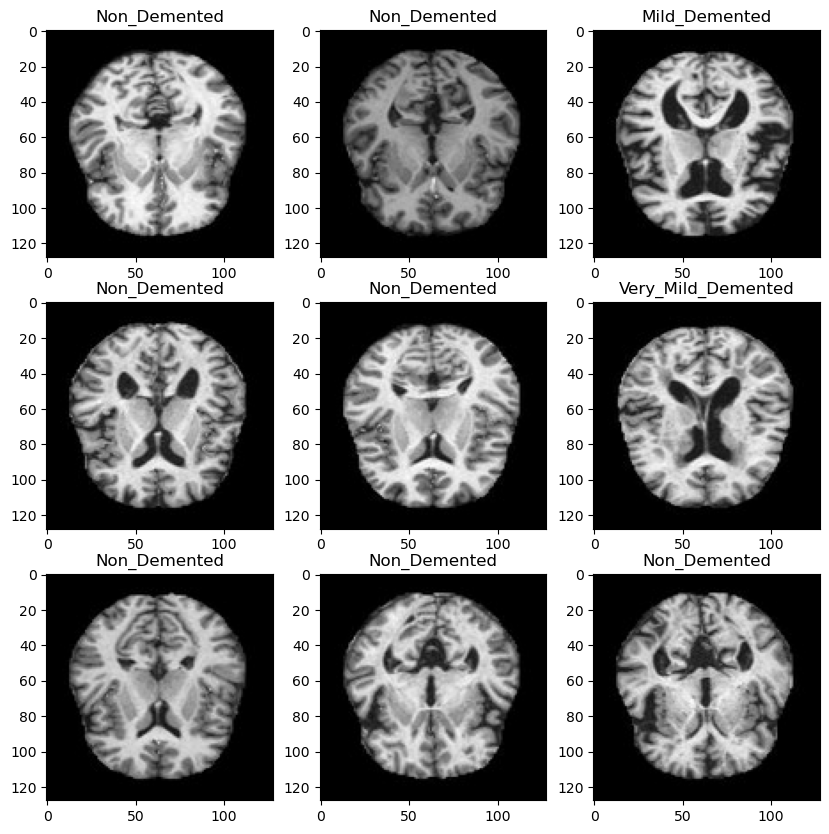

In [8]:
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0   

In [20]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [21]:
MODEL=modelvgg.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
410/410 [==============================] - 1495s 4s/step - loss: 1.0060 - auc: 0.8449 - val_loss: 0.9758 - val_auc: 0.8178
Epoch 2/10
410/410 [==============================] - 1350s 3s/step - loss: 0.6548 - auc: 0.9249 - val_loss: 1.3014 - val_auc: 0.7715
Epoch 3/10
410/410 [==============================] - 1492s 4s/step - loss: 0.5507 - auc: 0.9449 - val_loss: 1.3665 - val_auc: 0.8282
Epoch 4/10
410/410 [==============================] - 2308s 6s/step - loss: 0.4787 - auc: 0.9582 - val_loss: 1.0821 - val_auc: 0.8443
Epoch 5/10
410/410 [==============================] - 1580s 4s/step - loss: 0.3851 - auc: 0.9731 - val_loss: 0.7817 - val_auc: 0.8855
Epoch 6/10
410/410 [==============================] - 1058s 3s/step - loss: 0.3229 - auc: 0.9821 - val_loss: 0.9163 - val_auc: 0.8593
Epoch 7/10
410/410 [==============================] - 911s 2s/step - loss: 0.2740 - auc: 0.9875 - val_loss: 0.8344 - val_auc: 0.8867
Epoch 8/10
410/410 [==============================] - 37434s 92

In [22]:
from tensorflow.keras.models import load_model
modelvgg.save('VGG-19_model.h5')

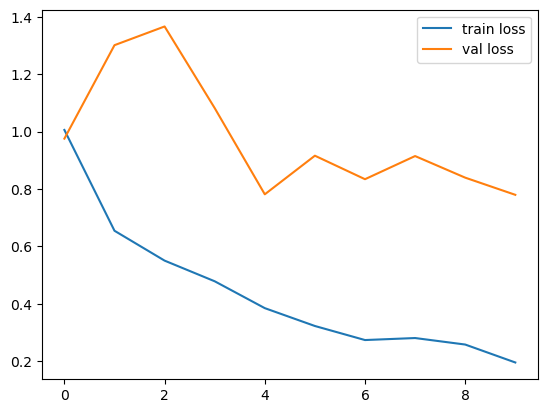

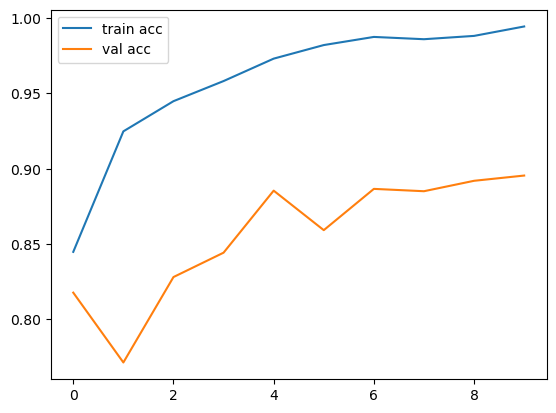

<Figure size 640x480 with 0 Axes>

In [26]:
plt.plot(MODEL.history['loss'], label='train loss')
plt.plot(MODEL.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(MODEL.history['auc'], label='train acc')
plt.plot(MODEL.history['val_auc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [137]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
'C:\\Users\\vishn\\Downloads\\data',
#seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
#batch_size=64
)



Found 1 files belonging to 1 classes.


In [138]:
predicted=modelvgg.predict(test_data)
print(predicted)
print(np.argmax(predicted,axis=1))

1/1 [==============================] - 0s 436ms/step
[[0. 0. 1. 0.]]
[2]


In [120]:
predicted

array([[0., 0., 1., 0.]], dtype=float32)

In [121]:
np.argmax(predicted,axis=1)

array([2], dtype=int64)

In [105]:
class_name[np.argmax(predicted)]

'Non_Demented'

In [50]:
class_name=test_ds.class_names
class_name

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [75]:
lod_model=load_model('VGG-19_model.h5')

In [134]:
lod_model.predict(test_data)

1/1 [==============================] - 1s 1s/step


array([[0., 0., 1., 0.]], dtype=float32)